## Imports

In [1]:
import scipy.io as sio

import sklearn as sk

import numpy as np

import matplotlib.pyplot as plt

## Loading Data

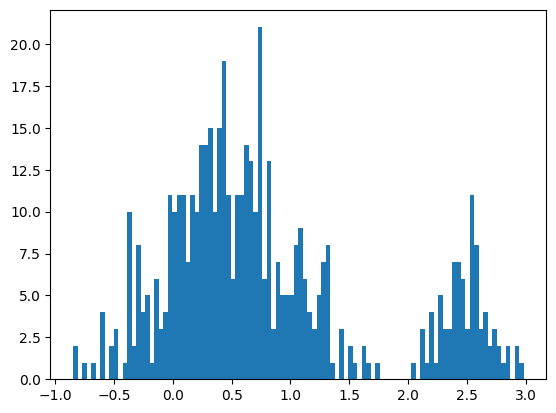

In [2]:
data = sio.loadmat('data/anomaly.mat')

x = data['X'].reshape(-1, 1)
test_1 = data['xtest1']
test_2 = data['xtest2']


plt.hist(x, bins=100)
plt.show()

## Kernel Density Estimation

In [28]:
class KDE:
    def __init__(self, sigma):
        self.sigma = sigma
    
    def rbf_kernel(self, x, sigma):
        return (sigma**2*2*np.pi)**(-self.d/2)*np.exp(-np.linalg.norm(x, axis=0)**2/(2*sigma**2))
    
    def fit(self, x):
        self.x = x
        self.n = x.shape[0]
        self.d = x.shape[1]
    
    def predict(self, x):
        x_train = self.x.reshape(self.d, 1, -1)
        x_in = x.reshape(self.d, -1, 1)
        return self.rbf_kernel((x_train - x_in), self.sigma).sum(axis=1)/self.n
        
    
    def ls_loocv_score(self):
        x = self.x

        col = x.reshape(x.shape[1], -1, 1)
        row = x.reshape(x.shape[1], 1, -1)

        root_2_kernel = self.rbf_kernel((col - row), (np.sqrt(2)*self.sigma))
        kernel = self.rbf_kernel((col - row), self.sigma)
        k_diag = np.diag(np.diagonal(kernel))
        kernel_sum = (kernel - k_diag).sum()*2/(self.n*(self.n - 1))
        root_2_kernel_sum = root_2_kernel.sum()/self.n**2

        return root_2_kernel_sum - kernel_sum

    def loo_outlier_score(self, x):
        train_x = self.x

        p = self.predict(x)
        
        col = train_x.reshape(self.d, -1, 1)
        row = train_x.reshape(self.d, 1, -1)
        kernel = self.rbf_kernel((col - row), self.sigma)
        k_diag = np.diag(np.diagonal(kernel))
        kernel_sum = (kernel - k_diag).sum()/(self.n*(self.n - 1))

        return p/kernel_sum
    
    def knn_outlier_score(self, x, k):
        train_x = self.x

        k_dists = np.linalg.norm(train_x - x, axis=1)
        k_nearest = np.argsort(k_dists)[:k]

        k_neighbors = train_x[k_nearest]

        k_neighbors_col = k_neighbors.reshape(self.d, -1, 1)
        train_x_row = train_x.reshape(self.d, 1, -1)
        dist_mat = np.linalg.norm(k_neighbors_col - train_x_row, axis=0)
        neighbors_k_neighbor = np.argsort(dist_mat, axis=1)[:,k]

        num = k_dists[k_nearest[k-1]]
        den = dist_mat[range(k), neighbors_k_neighbor].mean()
        return num/den




In [9]:
sigmas = np.linspace(0.01, 1, 1000)

scores = np.zeros(sigmas.shape[0])

for i, sigma in enumerate(sigmas):
    kde = KDE(sigma)
    kde.fit(x)
    scores[i] = kde.ls_loocv_score()

optimal_index = np.argmin(scores)

optimal_sigma = sigmas[optimal_index]
optimal_score = scores[optimal_index]

print(f"Sigma: {optimal_sigma}  with score: {optimal_score}")


Sigma: 0.08036036036036036  with score: -0.42972022737292


## Plotting KDE

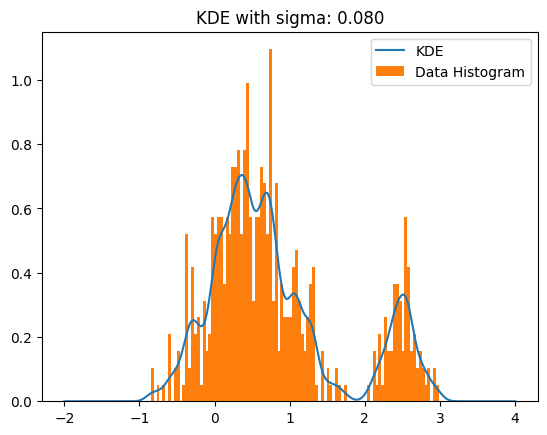

In [29]:
x_in = np.linspace(-2, 4, 1000)

kde = KDE(optimal_sigma)
kde.fit(x)
probs = kde.predict(x_in)


plt.plot(x_in, probs, label='KDE')
plt.hist(x, bins=100, density=True, label='Data Histogram')
plt.title(f"KDE with sigma: {optimal_sigma:.3f}")
plt.legend()
plt.show()

## Anomaly Detection 1

In [26]:
anomaly_1 = kde.loo_outlier_score(test_1)
anomaly_2 = kde.loo_outlier_score(test_2)

print(f"Anomaly 1 --- Value:{test_1[0,0]} --- Score:{anomaly_1}")
print(f"Anomaly 2 --- Value:{test_2[0,0]} --- Score:{anomaly_2}")

Anomaly 1 --- Value:2.85 --- Score:[0.17841943]
Anomaly 2 --- Value:-1.5 --- Score:[1.38076446e-16]


## Anomaly Detection 2

In [31]:
k_s = [100, 150, 200]

for k in k_s:
    anomaly_1 = kde.knn_outlier_score(test_1, k)
    anomaly_2 = kde.knn_outlier_score(test_2, k)

    print(f"Anomaly 1 --- K:{k} --- Value:{test_1[0,0]} --- Score:{anomaly_1}")
    print(f"Anomaly 2 --- K:{k} --- Value:{test_2[0,0]} --- Score:{anomaly_2}")
    print()

Anomaly 1 --- K:100 --- Value:2.85 --- Score:1.4118992231998948
Anomaly 2 --- K:100 --- Value:-1.5 --- Score:4.3980742072268875
Anomaly 3 --- K:100 --- Value:0.5 --- Score:1.0317531227410022

Anomaly 1 --- K:150 --- Value:2.85 --- Score:1.7090745349687244
Anomaly 2 --- K:150 --- Value:-1.5 --- Score:4.290340668880295
Anomaly 3 --- K:150 --- Value:0.5 --- Score:0.9377958512246192

Anomaly 1 --- K:200 --- Value:2.85 --- Score:1.9520914827588947
Anomaly 2 --- K:200 --- Value:-1.5 --- Score:3.9818072933953506
Anomaly 3 --- K:200 --- Value:0.5 --- Score:0.8914334833029426

